<a href="https://colab.research.google.com/github/nccreang/tr-KPFM/blob/master/tr_KPRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this section first if this is the first time using. 

In [0]:
%%capture
import sys
!{sys.executable} -m pip install pycroscopy
!{sys.executable} -m pip install pyUSID==0.0.5.1

This section loads all package dependencies of the code. 

In [0]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import ast
import pycroscopy as px
import h5py
import pyUSID as usid
from scipy import signal as si
from scipy.optimize import curve_fit

This section converts the data from .ibw to .h5 or will just use the .h5 file if already converted.  Change the input_file, scan_dir, scan_rate, and scan_size variables for what was used in the file being analyzed in the form to the right. Change the variable 'dim' to the distance between electrodes (in cm) of the sample to get the average electric field over the entire sample (not just the scanned area).

Note: Data translator will not accept non-square data (aka Partial data sets).

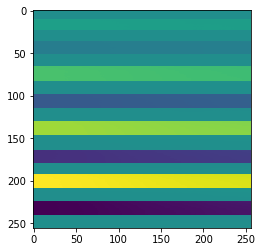

In [0]:
# Upload and input your file (.ibw or .h5)
input_file = "MSG4_undeg_low0000.ibw" #@param {type:"string"}
filename,ext = os.path.splitext(input_file)
scan_dir = "down" #@param {type:"string"}
scan_rate = 0.5 #@param {type:"number"} in Hz
scan_size = 70 #@param {type:"number"} in um
savefigs = "No" #@param ["Yes", "No"]
dim = 0.05 #@param {type:"number"}
if input_file.endswith('.ibw'):
  tl = px.io.translators.IgorIBWTranslator()
  h5_path=tl.translate(input_file)
if input_file.endswith('.h5'):
  h5_path = input_file
h5_file = h5py.File(h5_path)
h5_main = usid.hdf_utils.find_dataset(h5_file,'Raw_Data')
desr = [ii.data_descriptor for ii in h5_main]
subs = ['Amplitude','Potential','UserIn']
indx0 = [desr.index(list(filter(lambda x: ii in x, desr))[0]) for ii in subs]
amp_data = h5_main[indx0[0]]
pot_data = h5_main[indx0[1]]
volt_data = h5_main[indx0[2]]
ndim_form = volt_data.get_n_dim_form().shape

if scan_dir == 'down':
  volt = np.fliplr(np.flipud(np.reshape(volt_data,ndim_form[:2])))
  pot = np.fliplr(np.flipud(np.reshape(pot_data,ndim_form[:2])))
else:
  volt = np.reshape(volt_data,ndim_form[:2])
  pot = np.reshape(pot_data,ndim_form[:2])

plt.figure()
plt.imshow(pot)

This section finds where the voltage changes are during the scan and saves the scan line number in the variable indx. If the voltage was changed min-scan line, it uses the next scan line as the first scan of that voltage. 

In [0]:
t = np.array([ii for ii in range(ndim_form[0])])*(1/scan_rate)*2
y = np.linspace(0,scan_size,ndim_form[0])
cnttot = 0
count = 1
cntmax = 0
indx = []
vs=[]
for ii in range(1,len(t)):
  if np.rint(volt[ii,0]) != np.rint(volt[ii-1,0]):
    cnttot = cnttot+1 # counts the total number of voltage switches in the data set
    if np.rint(volt[ii,0]) != np.rint(volt[ii,-1]): #checks to see if the voltage is changed in the middle fo the scan line
      indx.append(ii+1)
    else:
      indx.append(ii)
      vs.append(volt[ii,0])
    if count > cntmax:
      cntmax = count
      count = 1
    else:
      count = 1
  else:
    count = count+1

This section plots the average CPD - static CPD per voltage vs distance and the CPD vs time for select distances (dist variable).  To view different distances change the vlaues in dist.

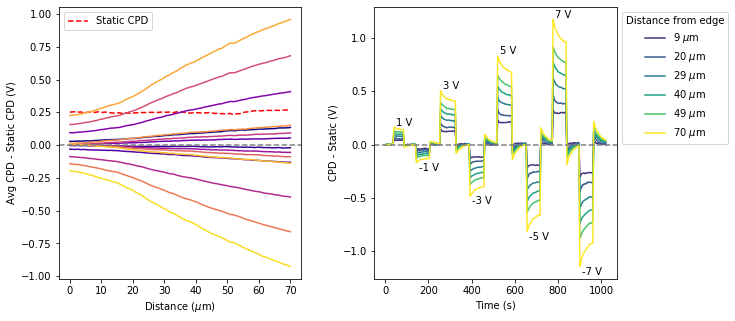

In [0]:
avgs = []
zeroavg = np.mean(pot[:indx[0]-1,:],axis =0)
for ii in range(len(indx)-1):
  avgs.append(np.mean(pot[indx[ii]:indx[ii+1]+1,:],axis=0)-zeroavg)

cmap = plt.cm.get_cmap('plasma',len(indx))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(y,zeroavg,'r--',label='Static CPD')
ax[0].set_xlabel('Distance ($\mu$m)')
if 'high' in filename:
  ax[0].set_ylabel('Avg CPD - Static - Applied Voltage (V)')
else:
  ax[0].set_ylabel('Avg CPD - Static CPD (V)')
for ii in range(len(avgs)):
  if 'high' in filename:
    v = vs[ii]
    if np.rint(v) == 0:
      continue
    else:
      ax[0].plot(y,avgs[ii]-v,c=cmap(ii))
  else:
    ax[0].plot(y,avgs[ii],c=cmap(ii))
ax[0].legend()
ax[0].axhline(y=0,color=(0.5,0.5,0.5),linestyle='--')


cmap1 = plt.cm.get_cmap('viridis',ndim_form[0])
dist = [10,20,30,40,50,y[-1]]
for ii in dist:
  ii = (np.abs(y-ii)).argmin()
  if 'high' in filename:
    v = volt[:,ii]
    ax[1].plot(t[:],pot[:,ii]-zeroavg[ii]-v,c=cmap1(ii),label=str(int(y[ii]))+' $\mu$m',linewidth=1.5)
  else:
    v = np.zeros(len(zeroavg))
    ax[1].plot(t[:],pot[:,ii]-zeroavg[ii],c=cmap1(ii),label=str(int(y[ii]))+' $\mu$m',linewidth=1.5)
ax[1].set_xlabel('Time (s)')
if 'high' in filename:
  ax[1].set_ylabel('CPD - Static - Aplied Voltage (V)')
else:
  ax[1].set_ylabel('CPD - Static (V)')
lgd=ax[1].legend(ncol=1,title='Distance from edge',bbox_to_anchor=(1,1), loc="upper left")
ax[1].axhline(y=0,color=(0.5,0.5,0.5),linestyle='--')
for k in indx:
  j = indx.index(k)
  if np.rint(vs[j])==0:
    continue
  if 'high' in filename:
    txty = pot[k,-1]-vs[j]-zeroavg[-1]
  else:
    txty = pot[k,-1]-zeroavg[-1]
  if txty>0:
    ax[1].text(t[k]+10,txty,str(int(np.rint(vs[j])))+' V',horizontalalignment='left',verticalalignment='bottom')
  else:
    ax[1].text(t[k]+10,txty,str(int(np.rint(vs[j])))+' V',horizontalalignment='left',verticalalignment='top')
fig.subplots_adjust(wspace=.3)

if savefigs == "Yes":
  name = filename + '_trKPFM_CPDvd_CPDvt.png'
  plt.savefig(name,bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#

This section will plot all of the raw data (not subtracting the static CPD), feel free to skip this section if you don't need to see the raw data. 

Note: plots in the subsequent sections have the zero biasing scans in the right column and scans with biasing in the left column.  The zero bias scans in the same row as the biasing are the relaxation after that biasing. 

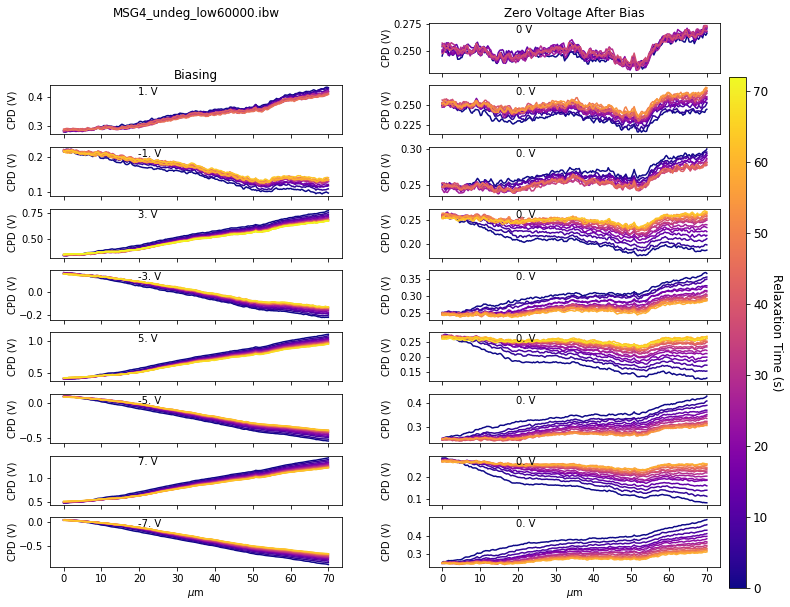

In [0]:
cnt = 2
jj = 0
cmap = plt.cm.get_cmap('plasma',cntmax)
cmapscale = t[0:cntmax]
fig,axs = plt.subplots(nrows=int(cnttot/2+1),ncols=2,sharex='col',figsize=(12,10))
axs[0,0].axis('off')
axs[0,0].set_title(input_file)
axs[1,0].set_title('Biasing')
axs[0,1].set_title('Zero Voltage After Bias')
axs[0,1].text(0.3,0.8,'0 V',transform = axs[0,1].transAxes)
axs[int(cnttot/2),0].set_xlabel('$\mu$m')
axs[int(cnttot/2),1].set_xlabel('$\mu$m')
cbaxs = fig.add_axes([0.91,0.095,0.02,0.71])
fig.subplots_adjust(hspace=0.25,wspace=0.25)
axs[0,1].set_ylabel('CPD (V)',rotation=90,labelpad=2)
axs[0,1].axvspan(y[0],0,facecolor='0.5',alpha=0.5)

col = 1
row = 0
lab = 0
for ii in range(len(t)):
  if np.rint(volt[ii,-1]) != np.rint(volt[ii,0]):
    jj = jj+1
    lab = 1
    continue
  if ii !=0:
    if lab ==1:
      prev = np.rint(volt[ii-2,0])
    else:
      prev = np.rint(volt[ii-1,0])
    if np.rint(volt[ii,0]) != prev:
      jj = 0
      if np.rint(volt[ii,0]) != 0:
        col = 0
        row = row+1
      else:
        col = 1
      S = np.array2string(np.rint(volt[ii,0])) +' V'
      axs[row,col].text(0.3,0.8,S,transform=axs[row,col].transAxes)
      axs[row,col].set_ylabel('CPD (V)',rotation=90,labelpad=2)
  yy = pot[ii,:]
  axs[row,col].plot(y,yy,c=cmap(jj))
  lab = 0
  jj = jj+1
scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=0,vmax=t[cntmax]))
scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Relaxation Time (s)',rotation=270,labelpad=15,size=12)
cbar.ax.tick_params(labelsize=12)
fig.align_ylabels(axs)
fig.subplots_adjust(wspace=.3)
if savefigs == "Yes":
  name = filename + '_trKPFM_rawCPD.png'
  plt.savefig(name,bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#

This section plots all scan lines subtracting the average static CPD before biasing to all biasing plots (left column).

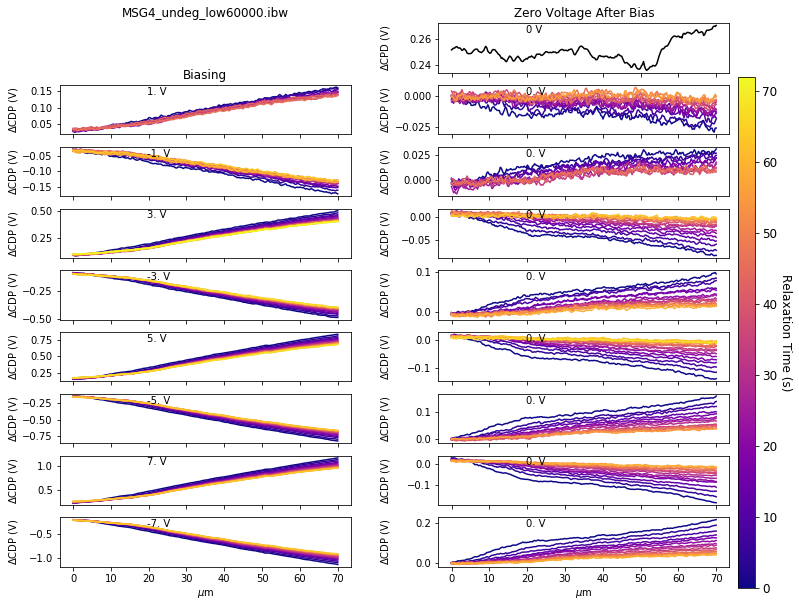

In [0]:
cnt = 2
jj = 0
cmap = plt.cm.get_cmap('plasma',cntmax)
cmapscale = t[0:cntmax]
fig, axs = plt.subplots(nrows=int(cnttot/2+1),ncols=2, sharex='col',figsize=(12,10))
axs[0,0].axis('off')
axs[0,0].set_title(input_file)
axs[1,0].set_title('Biasing')
axs[0,1].set_title('Zero Voltage After Bias')
axs[0,1].text(0.3,0.8,'0 V',transform = axs[0,1].transAxes)
axs[int(cnttot/2),0].set_xlabel('$\mu$m')
axs[int(cnttot/2),1].set_xlabel('$\mu$m')
cbaxs = fig.add_axes([0.91,0.095,0.02,0.71])
fig.subplots_adjust(hspace=0.25,wspace=0.25)
axs[0,1].set_ylabel('$\Delta$CPD (V)',rotation=90,labelpad=2)
axs[0,1].plot(y,zeroavg,'k-')

col = 1
row = 0
static=zeroavg
if np.rint(volt[indx[0]-1,-1]) != np.rint(volt[indx[0]-1,0]):
  lab = 1
else:
  lab = 0
for ii in range(indx[0],len(t)):
  if np.rint(volt[ii,-1]) != np.rint(volt[ii,0]):
    jj = jj +1
    lab = 1
    continue
  if ii != 0:
    if lab ==1:
      prev = np.rint(volt[ii-2,0])
    else:
      prev = np.rint(volt[ii-1,0])
    if np.rint(volt[ii,0]) != prev:
      jj = 0
      if np.rint(volt[ii,0]) !=0:
        col = 0
        row = row+1
        # static = zeroavg
      else:
        col = 1
        # static = 0
      S = np.array2string(np.rint(volt[ii,0]))+' V'
      axs[row,col].text(0.3,0.8,S,transform=axs[row,col].transAxes)
      axs[row,col].set_ylabel('$\Delta$CDP (V)',rotation=90,labelpad=2)
  yy = pot[ii,:] - static
  axs[row,col].plot(y,yy,c=cmap(jj))
  lab = 0
  jj = jj+1
scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=0,vmax=t[cntmax]))
scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Relaxation Time (s)',rotation=270,labelpad=15,size=12)
cbar.ax.tick_params(labelsize=12)
fig.align_ylabels(axs)
fig.subplots_adjust(wspace=.3)
if savefigs == "Yes":
  name = filename + '_trKPFM_CPD-static.png'
  plt.savefig(name,bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#

This section plots the E-field with static CPD removed. A savgol filter is used to smooth out the potential data. The parameters for the smoothing can be changed via the variables: window, poly (in form to the right, form may be hidden).  Be careful to not over-smooth the data, keep the smoothing variables unless you have to change them. 

Note: Biasing plots are using the last zero bias scan as the static CPD to account for any changes in the static CPD before the next voltage is applied. 

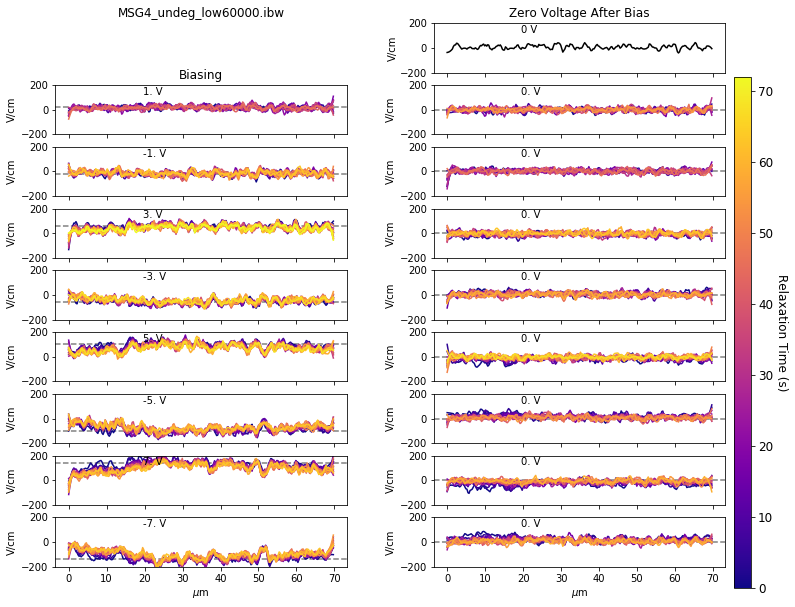

In [0]:
#@title Savgol Filter parameters
window = 13 #@param {type:"integer"}
poly = 3 #@param {type:"integer"}
cnt = 2
jj = 0
cmap = plt.cm.get_cmap('plasma',cntmax)
cmapscale = t[0:cntmax]
fig,axs = plt.subplots(nrows=int(cnttot/2+1),ncols=2,sharex='col',figsize=(12,10))
axs[0,0].axis('off')
axs[0,0].set_title(input_file)
axs[1,0].set_title('Biasing')
axs[0,1].set_title('Zero Voltage After Bias')
axs[0,1].text(0.3,0.8,'0 V',transform = axs[0,1].transAxes)
axs[int(cnttot/2),0].set_xlabel('$\mu$m')
axs[int(cnttot/2),1].set_xlabel('$\mu$m')
cbaxs = fig.add_axes([0.91,0.095,0.02,0.71])
fig.subplots_adjust(hspace=0.25,wspace=0.25)
axs[0,1].set_ylabel('V/cm',rotation=90,labelpad=2)
smooth = si.savgol_filter(pot[ii,:]-zeroavg,window,poly)
zeroE = np.diff(smooth)/np.diff(y)*1e4
axs[0,1].plot(y[:-1],zeroE,'k-')

col = 1
row = 0
if np.rint(volt[indx[0]-1,-1]) != np.rint(volt[indx[0]-1,0]):
  lab = 1
else:
  lab = 0
for ii in range(indx[0],len(t)):
  if np.rint(volt[ii,-1]) != np.rint(volt[ii,0]):
    jj = jj +1
    lab = 1
    continue
  if ii != 0:
    if lab ==1:
      prev = np.rint(volt[ii-2,0])
    else:
      prev = np.rint(volt[ii-1,0])
    if np.rint(volt[ii,0]) != prev:
      jj = 0
      if np.rint(volt[ii,0])!=0:
        col = 0
        row = row+1
        if lab==1:
          zero_pot = pot[ii-2,:]
        else:
          zero_pot = pot[ii-1,:]
      else:
        col = 1
        zero_pot = zeroavg
      axs[row,col].axhline(y=(volt[ii,0]/dim),color=(0.5,0.5,0.5),linestyle='--') # E-field for full sample
      S = np.array2string(np.rint(volt[ii,0]))+' V'
      axs[row,col].text(0.3,0.8,S,transform=axs[row,col].transAxes)
      axs[row,col].set_ylabel('V/cm')
    if ii == indx[0]:
      zero_pot = zeroavg
  smooth = si.savgol_filter(pot[ii,:]-zero_pot,window,poly)
  yy = np.diff(smooth)/np.diff(y)*1e4
  if 'high' in filename:
    yy = -yy
  axs[row,col].plot(y[:-1],yy,c=cmap(jj))
  lab = 0
  jj = jj+1

scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=0,vmax=t[cntmax]))
scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Relaxation Time (s)',rotation=270,labelpad=15,size=12)
cbar.ax.tick_params(labelsize=12)
fig.align_ylabels(axs)
fig.subplots_adjust(wspace=.3)
plt.setp(axs,ylim=(-200,200))

if savefigs == "Yes":
  name = filename + '_trKPFM_Efield.png'
  plt.savefig(name,bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#

This section separates all the relaxations and fits each voltage relaxation to an exponential decay of the form: $\Phi = \alpha e^{-t/\tau} + \beta$. 

Relaxations during biasing are the top row while the relaxation after biasing are the bottom row.  Each column is a different distance away from the edge or end of scan. 

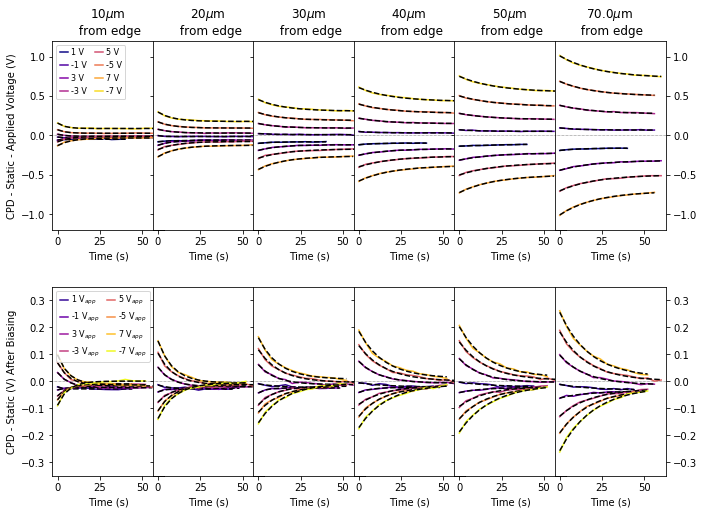

In [0]:
t_const = []
t_const_z = []
a_vals = []
b_vals = []
a_vals_z = []
b_vals_z = []
lin0=[]
lin1=[]
p=-1
cmap = plt.cm.get_cmap('plasma',len(indx))

def exp_decay(x,a,b,k):
  return a*np.exp(x*k) + b
fig,ax=plt.subplots(ncols=len(dist),nrows=2,figsize=(11,8))
ax[1,0].set_ylabel('CPD - Static (V) After Biasing')
if 'high' in filename:
  ax[0,0].set_ylabel('CPD - Static - Applied Voltage (V)')
else:
  ax[0,0].set_ylabel('CPD - Static (V)')
for k in dist:
  jj = (np.abs(y-k)).argmin()
  p=p+1
  t_c = []
  a_0 = []
  b_0 = []
  t_z = []
  a_z = []
  b_z = []
  ax[0,p].set_xlabel('Time (s)')
  ax[1,p].set_xlabel('Time (s)')
  ax[0,p].yaxis.set_ticks_position('both')
  ax[1,p].yaxis.set_ticks_position('both')
  ax[0,p].title.set_text(str(k)+'$\mu$m \n from edge')
  ax[0,p].axhline(y=0,linestyle=':',linewidth=0.5,color='k')
  ax[1,p].axhline(y=0,linestyle=':',linewidth=0.5,color='k')

  if p!=0:
    if k!=dist[-1]:
      ax[0,p].set_yticklabels('')
      ax[1,p].set_yticklabels('')
    else:
      ax[0,p].yaxis.tick_right()
      ax[1,p].yaxis.tick_right()

  for ii in range(len(indx)):
    if np.rint(volt[indx[ii],0])==0:
      if indx[ii]==indx[-1]:
        y_array = pot[indx[ii]:-1,jj]-zeroavg[jj]
      else:
        y_array = pot[indx[ii]:indx[ii+1]-1,jj]-zeroavg[jj]
      x_array = t[:len(y_array)]
      lin1+=ax[1,p].plot(x_array,y_array,c=cmap(ii),label=str(int(np.rint(volt[indx[ii-1],0])))+' V$_{app}$')
      if volt[indx[ii-1],0]>0:
        yint = np.min(y_array)
      else:
        yint = np.max(y_array)
      popt, pcov = curve_fit(exp_decay, x_array, y_array, p0=[0.5,yint, -0.5])
      ax[1,p].plot(x_array,exp_decay(x_array,*popt),color='k',linestyle='--')
      t_z.append(popt[2])
      b_z.append(popt[1])
      a_z.append(popt[0])
    else:
      if 'high' in filename:
        y_array = pot[indx[ii]:indx[ii+1]-1,jj]-zeroavg[jj]-volt[indx[ii],jj]
      else: 
        y_array = pot[indx[ii]:indx[ii+1]-1,jj]-zeroavg[jj]
      x_array = t[:len(y_array)]
      lin0 += ax[0,p].plot(x_array,y_array,c=cmap(ii),label=str(int(np.rint(volt[indx[ii],0])))+' V')
      if volt[indx[ii],0]>0:
        yint = np.max(y_array)
      else:
        yint = np.min(y_array)
      popt, pcov = curve_fit(exp_decay, x_array, y_array, p0=[0.5,yint, -0.5])
      ax[0,p].plot(x_array,exp_decay(x_array,*popt),color='k',linestyle='--')
      t_c.append(popt[2])
      b_0.append(popt[1])
      a_0.append(popt[0])
  if len(t_const)==0:
    t_const = np.asarray(t_c)
    a_vals = np.asarray(a_0)
    b_vals = np.asarray(b_0)
  else:
    t_const = np.vstack((t_const,np.asarray(t_c)))
    a_vals = np.vstack((a_vals,np.asarray(a_0)))
    b_vals = np.vstack((b_vals,np.asarray(b_0)))
  if len(t_const_z)==0:
    t_const_z = np.asarray(t_z)
    a_vals_z = np.asarray(a_z)
    b_vals_z = np.asarray(b_z)
  else:
    t_const_z= np.vstack((t_const_z,np.asarray(t_z)))
    a_vals_z = np.vstack((a_vals_z,np.asarray(a_z)))
    b_vals_z = np.vstack((b_vals_z,np.asarray(b_z)))
fig.subplots_adjust(wspace=-.1)
fig.subplots_adjust(hspace=0.3)

plt.setp(ax[0,:],ylim=(-1.2,1.2))
plt.setp(ax[1,:],ylim=(-0.35,0.35))
leg=ax[0,0].legend(ncol=2,handlelength=1.0,handletextpad=0.4,loc='upper left',columnspacing=1,prop={'size': 8})
leg=ax[1,0].legend(ncol=2,handlelength=1.0,handletextpad=0.4,loc='upper left',columnspacing=1,prop={'size': 8})

if savefigs == "Yes":
  name = filename + '_decay_curves.png'
  plt.savefig(name,bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#

This section plots the fitting parameters of the exponenetial decay, $\Phi = \alpha e^{-t/\tau} + \beta$: exponential time ($\alpha$), and total potential change from beginning to saturation ($\beta$). 

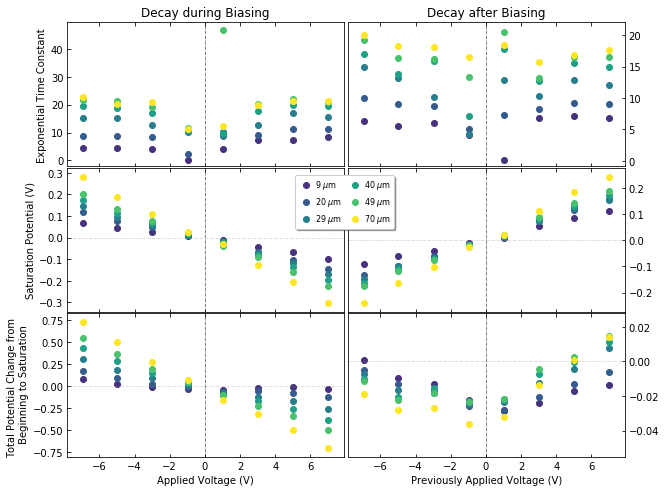

In [0]:
voltages = [volt[k,0] for k in indx if np.rint(volt[k,0])!=0]
cmap1 = plt.cm.get_cmap('viridis',ndim_form[0])
fig,ax=plt.subplots(nrows=3,ncols=2,sharex='col',figsize=(10,8))
ax[0,0].title.set_text('Decay during Biasing')
ax[0,1].title.set_text('Decay after Biasing')
for ii in range(len(dist)):
  jj = (np.abs(y-dist[ii])).argmin()
  ax[0,0].scatter(voltages,-1/t_const[ii,:],color=cmap1(jj))
  ax[1,0].scatter(voltages,a_vals[ii,:],color=cmap1(jj))
  ax[2,0].scatter(voltages,b_vals[ii,:],color=cmap1(jj))
  ax[0,1].scatter(voltages,-1/t_const_z[ii,:],color=cmap1(jj))
  ax[1,1].scatter(voltages,a_vals_z[ii,:],color=cmap1(jj),label=str(int(y[jj]))+' $\mu$m')
  ax[2,1].scatter(voltages,b_vals_z[ii,:],color=cmap1(jj))
ax[0,0].set_ylabel('Exponential Time Constant')
ax[1,0].set_ylabel('Saturation Potential (V)')
ax[2,0].set_ylabel('Total Potential Change from \n Beginning to Saturation')
ax[2,0].set_xlabel('Applied Voltage (V)')
ax[2,1].set_xlabel('Previously Applied Voltage (V)')
if 'high' in filename:
  ax[1,1].legend(bbox_to_anchor=(0.18,0.55),ncol=2,handletextpad=0.1,columnspacing=0.6,shadow=True,prop={'size': 8})
else:
  ax[1,1].legend(bbox_to_anchor=(0.175,0.5),ncol=2,handletextpad=0.1,columnspacing=0.6,shadow=True,prop={'size': 8})
for ii in range(3):
  ax[ii,0].axvline(x=0,linestyle='-.',color='k',linewidth=0.5)
  ax[ii,0].xaxis.set_ticks_position('both')
  ax[ii,0].tick_params(direction='in')
  ax[ii,1].axvline(x=0,linestyle='-.',color='k',linewidth=0.5)
  ax[ii,1].xaxis.set_ticks_position('both')
  ax[ii,1].tick_params(direction='in')
  ax[ii,1].yaxis.tick_right()
fig.subplots_adjust(hspace=0.01)
fig.subplots_adjust(wspace=0.015)
ax[1,0].axhline(y=0,linestyle='-.',color=(0.5,0.5,0.5,0.5),linewidth=0.5)
ax[2,0].axhline(y=0,linestyle='-.',color=(0.5,0.5,0.5,0.5),linewidth=0.5)
ax[1,1].axhline(y=0,linestyle='-.',color=(0.5,0.5,0.5,0.5),linewidth=0.5)
ax[2,1].axhline(y=0,linestyle='-.',color=(0.5,0.5,0.5,0.5),linewidth=0.5)
# ax[0,1].set_ylim((0,50))
# ax[2,1].set_ylim((-0.03,0.03))
if savefigs == "Yes":
  name = filename + '_decay_params.png'
  plt.savefig(name,bbox_inches='tight',dpi=1080) # for lower quality image/smaller size image, change dpi or remove dip=#